# This code demonstrates a Hidden markov modeling of conformational transitions from AFM images

# load required packages

In [1]:
using Statistics, Plots, DelimitedFiles
using Revise; using MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/BqeJF/src/Revise.jl:1328


In [2]:
using BSON: @save, @load
@load "data/t1r/t1r.bson" C T pi_i p_all indexOfCluster tau pdb psf

In [3]:
nstate = size(T, 1)

50

# generate AFM data

In [4]:
nframe = 1000
state = msmgenerate(nframe, T, pi_i);

In [28]:
state

1000-element Array{Int64,1}:
 33
  5
 11
 17
 33
 11
 41
 45
 33
 17
 25
 15
 24
  ⋮
 34
 38
 38
  3
 16
 28
  3
 38
  3
 38
 28
 34

# calculate emissions

In [90]:
# quaternion
qs = readdlm("data/quaternion/QUATERNION_LIST_576_Orient");

In [91]:
# model
models = pdb
for iatom = 1:models.natom
    models.atomname[iatom] = models.resname[iatom]
end
decenter!(models)
models = superimpose(models[1, :], models);

In [92]:
# afm
probe_radius = 20.0
afmize_config = AfmizeConfig(10.0 * (pi / 180),
    probe_radius, 
    MDToolbox.Point2D(-250, -200), 
    MDToolbox.Point2D(250, 200), 
    MDToolbox.Point2D(6.25, 6.25), 
    MDToolbox.defaultParameters())

sigma_noise = 3.0

afms = []
for iframe in 1:nframe
    model = models[state[iframe], :]
    afm = afmize(model, afmize_config)
    h, w = size(afm)
    afm .+= randn(h, w) * sigma_noise
    push!(afms, afm)
end
@save "msm_hmm_afm.bson" afms models state qs afmize_config probe_radius sigma_noise

In [93]:
#anim = @animate for i = 1:length(afms)
#    heatmap(afms[i])
#end
#gif(anim, "msm_hmm_afm.gif", fps = 10)

In [94]:
configs = [AfmizeConfig(10.0 * (pi / 180),
    r, 
    MDToolbox.Point2D(-250, -200), 
    MDToolbox.Point2D(250, 200), 
    MDToolbox.Point2D(6.25, 6.25), 
    MDToolbox.defaultParameters())
    for r in [10.0, 15.0, 20.0, 25.0, 30.0]]

5-element Array{AfmizeConfig,1}:
 AfmizeConfig(0.17453292519943295, 10.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 15.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 20.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 25.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point

In [24]:
res = []
for i = 1:nframe
    @show i
    res2 = getafmposterior(afms[i], models, qs, configs)
    push!(res, res2)
end

i = 1
size(model_array, 1) = 5
imodel = 3
imodel = 4
imodel = 5
imodel = 1
imodel = 2
i = 2
size(model_array, 1) = 5
imodel = 3
imodel = 4
imodel = 5
imodel = 1
imodel = 2


In [4]:
@load "msm_hmm_afm.bson" afms models state qs afmize_config probe_radius sigma_noise
@load "msm_hmm_afm.posterior.bson" res

In [31]:
res[3][1]

30

In [8]:
nframe = 1000

1000

In [9]:
emission = zeros(Float64, nstate, nframe)
for i = 1:nframe
    emission[:, i] .= res[i][end]
end

emission .= emission .+ 0.0001
emission .= emission ./ sum(emission, dims=1)

50×1000 Array{Float64,2}:
 9.95025e-5   9.95025e-5  9.95025e-5  …  9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     0.995124    9.95025e-5  0.995124
 9.95025e-5   9.95025e-5  9.95025e-5  …  9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 0.00221586   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 0.000104094  0.995124    9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5  …  9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5  9.95025e-5
 9.95025e-5   9.95025e-5  9.95025e-5     9.95025e-5  9.95025e-5 

In [10]:
observation = collect(1:nframe)

1000-element Array{Int64,1}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
  989
  990
  991
  992
  993
  994
  995
  996
  997
  998
  999
 1000

# Hidden markov modeling

In [11]:
# initial transition probabilities
T0 = rand(Float64, nstate, nstate)
T0 .= T0 ./ sum(T0, dims=2)
pi_i = T0[1, :]

50-element Array{Float64,1}:
 0.010985105476028567
 0.024868477638022437
 0.02099237360747884
 0.01773368166562382
 0.03300165770540196
 0.02121399182736977
 0.021725266862160905
 0.03113814929152337
 0.002754170275674734
 0.023904813897307964
 0.03411253438046555
 0.023460411866993176
 0.01976729673387591
 ⋮
 0.009369839840035254
 0.03081859270236924
 0.0005761377307488546
 0.02036963262591888
 0.020436232256663703
 0.019766874930260903
 0.003759844763857185
 0.030224042594140316
 0.0018558330318280726
 0.0129955854094754
 0.027689709139653074
 0.03004817471848734

In [12]:
@time T1, pi_i1, emission1 = msmbaumwelch([observation], T0, pi_i, emission);

  4.822765 seconds (7.47 M allocations: 2.565 GiB, 8.52% gc time)


In [13]:
T1

50×50 Array{Float64,2}:
 0.0           2.41446e-285  0.0           …  9.61572e-290  7.99452e-285
 4.63933e-203  0.0519616     7.69353e-216     0.0254063     0.0247143
 0.0           1.79503e-292  0.0              1.90591e-292  8.7892e-295
 3.07188e-170  0.0815957     6.14372e-174     1.26705e-75   8.2564e-76
 2.44877e-148  2.38859e-79   8.14717e-150     5.71713e-83   8.2401e-95
 1.25851e-168  0.105309      1.08394e-171  …  0.0524369     0.0525826
 0.0           6.02429e-294  0.0              1.82069e-294  6.35786e-297
 7.31245e-238  1.0           3.35988e-240     2.97747e-70   7.98615e-77
 2.12702e-169  1.36913e-77   5.06471e-169     1.13091e-77   3.87925e-84
 1.84704e-229  1.45124e-82   4.80029e-232     5.94078e-84   1.00077e-88
 3.50525e-212  1.0           3.73572e-216  …  2.35818e-96   1.01875e-142
 1.63017e-156  1.02618e-91   6.53979e-158     2.95614e-90   6.29691e-100
 2.77609e-241  2.10199e-79   1.68779e-239     8.17228e-84   3.10881e-98
 ⋮                                        

# visualization

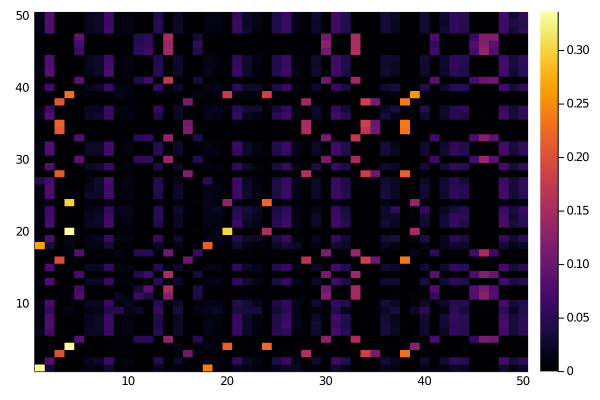

In [14]:
heatmap(T, zlim=(0,0.3))  

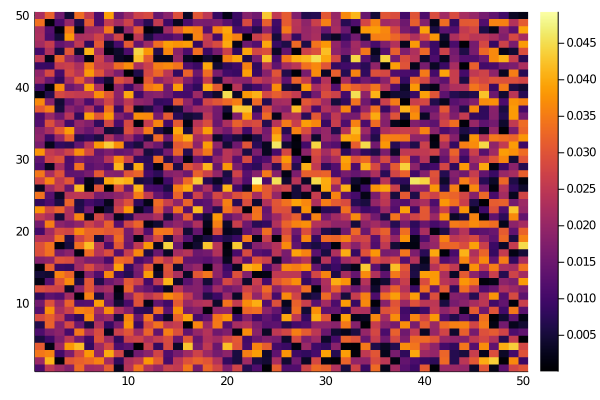

In [15]:
heatmap(T0, zlim=(0,0.3))

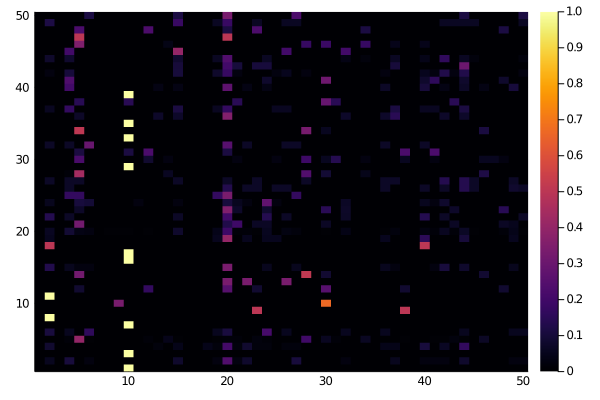

In [16]:
heatmap(T1, zlim=(0,0.3))

# Viterbi algorithm

In [19]:
@time state_estimated = msmviterbi(observation, T1, pi_i1, emission1);

  0.934752 seconds (2.40 M allocations: 120.308 MiB)


In [20]:
state_estimated2 = zeros(Int64, nframe);
for iframe = 1:nframe
    state_estimated2[iframe] = argmax(emission[:, iframe])
end

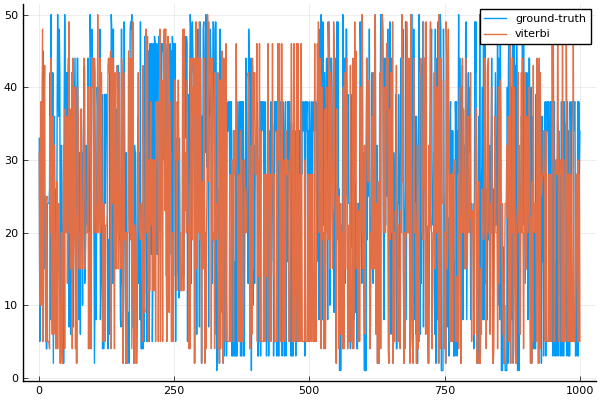

In [26]:
pyplot()
plot(state, line=(1), label="ground-truth")
plot!(state_estimated, line=(1), label="viterbi", legend=:topright)
#plot!(state_estimated2[1:300], line=(1), label="argmax", legend=:topright)